Cache kullanıldı.
Toplam veri sayısı: 100000


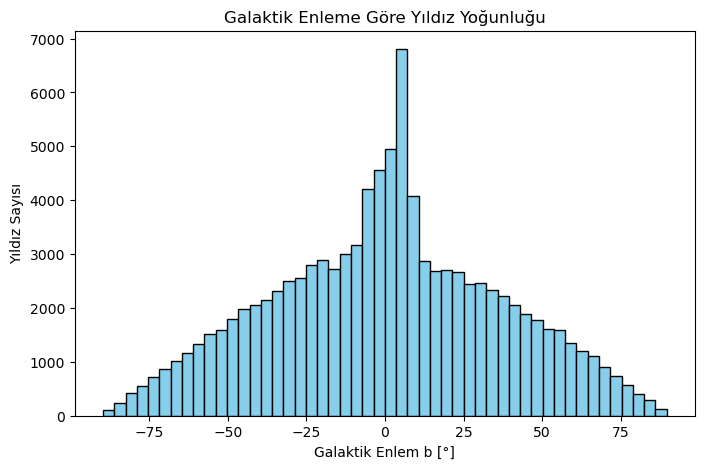

interactive(children=(IntSlider(value=20, description='radius', min=1), Output()), _dom_classes=('widget-inter…

<function __main__.plot_3d_interactive(radius=20)>

In [1]:
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider

def fetch_gaia_data(limit=100000):
    query = f"""
    SELECT TOP {limit}
           source_id, ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
    FROM gaiadr3.gaia_source
    WHERE parallax > 0
      AND phot_g_mean_mag IS NOT NULL
      AND phot_bp_mean_mag IS NOT NULL
      AND phot_rp_mean_mag IS NOT NULL
      AND ruwe < 1.4
    ORDER BY parallax DESC
    """
    job = Gaia.launch_job_async(query)
    return job.get_results().to_pandas()

try:
    df = pd.read_csv("gaia_nearby_cache.csv")
    print("Cache kullanıldı.")
except:
    df = fetch_gaia_data()
    df.to_csv("gaia_nearby_cache.csv", index=False)
    print("Veri çekildi ve kaydedildi.")
print(f"Toplam veri sayısı: {len(df)}")


coords = SkyCoord(ra=df['ra'].values*u.deg, dec=df['dec'].values*u.deg, 
                  distance=(1000/df['parallax'].values)*u.pc, frame='icrs')
galactic = coords.galactic
df['l'] = galactic.l.deg
df['b'] = galactic.b.deg
df['x'] = (coords.distance * np.cos(galactic.b.radian) * np.cos(galactic.l.radian)).value
df['y'] = (coords.distance * np.cos(galactic.b.radian) * np.sin(galactic.l.radian)).value
df['z'] = (coords.distance * np.sin(galactic.b.radian)).value
df['M_G'] = df['phot_g_mean_mag'] - 5*np.log10((coords.distance).value/10)
df['BP_RP'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']

def plot_3d_interactive(radius=20):
    mask = (np.sqrt(df['x']**2 + df['y']**2 + df['z']**2) <= radius)
    sub = df[mask]

    dist = np.sqrt(sub['x']**2 + sub['y']**2 + sub['z']**2)
    sizes = 6 - 4*(dist/dist.max())
    colors = dist

    fig = go.Figure()
    
    # Yıldızlar
    fig.add_trace(go.Scatter3d(
        x=sub['x'], y=sub['y'], z=sub['z'],
        mode='markers',
        marker=dict(size=sizes, color=colors, colorscale='Viridis', colorbar=dict(title='Distance [pc]')),
        name='Stars'
    ))



    # Güneş (merkez)
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers',
        marker=dict(size=8, color='yellow', symbol='circle'),
        name='Sun'
    ))

    fig.update_layout(
        title=f"Güneş merkezli 3D dağılım (r ≤ {radius} pc)",
        scene=dict(
            xaxis_title='X [pc]',
            yaxis_title='Y [pc]',
            zaxis_title='Z [pc]',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        transition={'duration': 500}
    )
    fig.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['b'], bins=50, color='skyblue', edgecolor='k')
plt.xlabel('Galaktik Enlem b [°]')
plt.ylabel('Yıldız Sayısı')
plt.title('Galaktik Enleme Göre Yıldız Yoğunluğu')
plt.show()



interact(plot_3d_interactive, radius=IntSlider(min=1, max=100, step=1, value=20))